<a href="https://colab.research.google.com/github/kongwanbianjinyu/Deep-Learning-Tutorial/blob/main/Adversarial_Robustness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

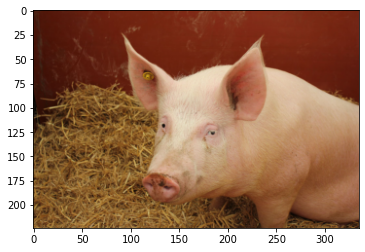

In [2]:
from PIL import Image
from torchvision import transforms
from matplotlib import pyplot as plt

# read the image, resize to 224 and convert to PyTorch Tensor
pig_img = Image.open("/content/drive/MyDrive/deep learning tutorial/data/Show_Pig_(18097041013).jpeg")
preprocess = transforms.Compose([
   transforms.Resize(224),
   transforms.ToTensor(),
])
# add batch dim: [B,C,H,W]
pig_tensor = preprocess(pig_img)[None,:,:,:] 

# plot image (note that numpy using HWC whereas Pytorch user CHW, so we need to convert)
plt.imshow(pig_tensor[0].numpy().transpose(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

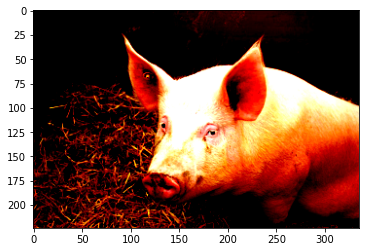

In [3]:
import torch
import torch.nn as nn
from torchvision.models import resnet50

# values are standard normalization for ImageNet images, 
# from https://github.com/pytorch/examples/blob/master/imagenet/main.py
DATA_MEANS = [0.485, 0.456, 0.406]
DATA_STD = [0.229, 0.224, 0.225]

# simple Module to normalize an image
norm = transforms.Compose([
                          transforms.Normalize(DATA_MEANS, DATA_STD)
                          ])

norm_pig = norm(pig_tensor)
plt.imshow(norm_pig[0].numpy().transpose(1,2,0))
# load pre-trained ResNet50, and put into evaluation mode (necessary to e.g. turn off batchnorm)
model = resnet50(pretrained=True)
model.eval()

In [4]:
# form predictions
pred = model(norm(pig_tensor))
print(pred.shape)

torch.Size([1, 1000])


In [5]:
import json
with open("/content/drive/MyDrive/deep learning tutorial/data/imagenet_class_index.json") as f:
    # imagenet_classes dict: {index : class_name}
    imagenet_classes = {int(i):x[1] for i,x in json.load(f).items()}
# pred.max(dim=1) return values and indices, we need indices. The item() can convert tensor to number
print(imagenet_classes[pred.max(dim=1)[1].item()])

hog


# Adversarial Example

In [6]:
import torch.optim as optim
epsilon = 2./255

delta = torch.zeros_like(pig_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=1e-1)

for t in range(30):
    pred = model(norm(pig_tensor + delta))
    # 341 is the hog index label
    loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([341]))
    if t % 5 == 0:
        print(t, loss.item())
    
    opt.zero_grad()
    # delta = delta - Grad_{delta}(-CrossEntropyLoss())
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)
    
print("True class probability:", nn.Softmax(dim=1)(pred)[0,341].item())

0 -0.007959788665175438
5 -0.030653396621346474
10 -5.1599931716918945
15 -13.03407096862793
20 -10.148152351379395
25 -20.480581283569336
True class probability: 1.6817374159927567e-08


In [20]:
max_class = pred.max(dim=1)[1].item()
# The predicted class is not hog anymore, it fool the network to candle
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

Predicted class:  candle
Predicted probability: 0.9994345307350159


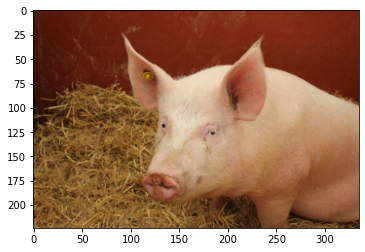

In [14]:
plt.imshow((pig_tensor + delta)[0].detach().numpy().transpose(1,2,0))

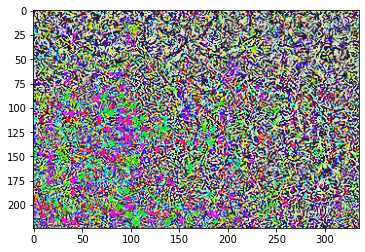

In [17]:
# To show the perturbation, we zoom facter of 50.
plt.imshow((50*delta + 0.5)[0].detach().numpy().transpose(1,2,0))

# Targeted Adversarial Example

In [21]:
import torch.optim as optim
epsilon = 2./255

delta = torch.zeros_like(pig_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=5e-3)

for t in range(100):
    pred = model(norm(pig_tensor + delta))
    # 341 is the hog index label, 404 is the target index label
    loss =  nn.CrossEntropyLoss()(pred, torch.LongTensor([404])) - nn.CrossEntropyLoss()(pred, torch.LongTensor([341]))
    if t % 10 == 0:
        print(t, loss.item())
    
    opt.zero_grad()
    # delta = delta - Grad_{delta}(loss())
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)
    
print("True class probability:", nn.Softmax(dim=1)(pred)[0,341].item())

0 18.7014102935791
10 1.9300079345703125
20 -4.075088977813721
30 -10.824923515319824
40 -18.533342361450195
50 -23.965614318847656
60 -29.816146850585938
70 -35.05791473388672
80 -39.11615753173828
90 -41.85273361206055
True class probability: 8.314640995004739e-21


In [22]:
max_class = pred.max(dim=1)[1].item()
# The predicted class is not hog anymore, it fool the network to candle
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

Predicted class:  airliner
Predicted probability: 0.9942810535430908


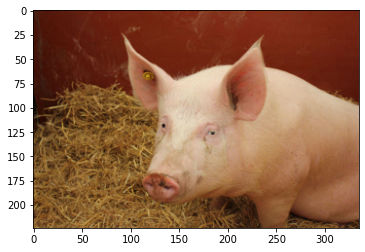

In [23]:
plt.imshow((pig_tensor + delta)[0].detach().numpy().transpose(1,2,0))

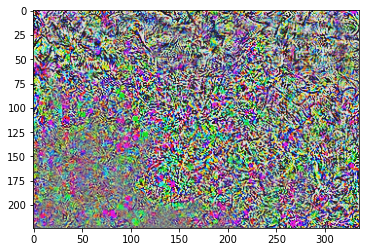

In [24]:
# To show the perturbation, we zoom facter of 50.
plt.imshow((50*delta + 0.5)[0].detach().numpy().transpose(1,2,0))

# Adversarial Training - Linear Model

In [28]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

mnist_train = datasets.MNIST("./data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("./data", train=False, download=True, transform=transforms.ToTensor())

# we only need digits number 0 / 1 as binary classification problem
train_idx = mnist_train.targets <= 1
mnist_train.data = mnist_train.data[train_idx]
mnist_train.targets = mnist_train.targets[train_idx]

test_idx = mnist_test.targets <= 1
mnist_test.data = mnist_test.data[test_idx]
mnist_test.targets = mnist_test.targets[test_idx]

train_loader = DataLoader(mnist_train, batch_size = 100, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size = 100, shuffle=False)


## Traditionally train the model 

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim

# do a single pass over the data
def epoch(loader, model, opt=None):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        yp = model(X.view(X.shape[0], -1))[:,0]
        loss = nn.BCEWithLogitsLoss()(yp, y.float())
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += ((yp > 0) * (y==0) + (yp < 0) * (y==1)).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

In [30]:
model = nn.Linear(784, 1)
opt = optim.SGD(model.parameters(), lr=1.)
print("Train Err", "Train Loss", "Test Err", "Test Loss", sep="\t")
for i in range(10):
    train_err, train_loss = epoch(train_loader, model, opt)
    test_err, test_loss = epoch(test_loader, model)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

Train Err	Train Loss	Test Err	Test Loss
0.006159	0.015360	0.000473	0.003287
0.001500	0.005314	0.000473	0.002608
0.001184	0.004395	0.000473	0.002255
0.001184	0.003872	0.000473	0.002096
0.001105	0.003507	0.000946	0.002055
0.001026	0.003262	0.000946	0.002012
0.000869	0.002929	0.000473	0.001964
0.000711	0.002651	0.000473	0.001963
0.000790	0.002656	0.000946	0.001825
0.000790	0.002466	0.000946	0.001810


# Get adversarial perturbation

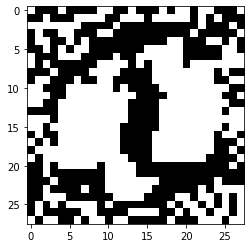

In [31]:
epsilon = 0.2
delta = epsilon * model.weight.detach().sign().view(28,28)
plt.imshow(1-delta.numpy(), cmap="gray")

## Observe how the adversarial perturbation increase the test error

In [32]:
def epoch_adv(loader, model, delta):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        # class label y = 0, we use -1. class label y = 1, we use +1
        # adversarial perturbation on image X
        yp = model((X-(2*y.float()[:,None,None,None]-1)*delta).view(X.shape[0], -1))[:,0]
        loss = nn.BCEWithLogitsLoss()(yp, y.float())
        total_err += ((yp > 0) * (y==0) + (yp < 0) * (y==1)).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)
print(epoch_adv(test_loader, model, delta[None,None,:,:]))

(0.840661938534279, 3.336431196677206)


## Adversarial train the model

In [39]:
# do a single pass over the data
def epoch_robust(loader, model, epsilon, opt=None):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        # pred - y * \epsilon * ||w||_1
        yp = model(X.view(X.shape[0], -1))[:,0] - epsilon*(2*y.float() - 1)*model.weight.norm(1)
        loss = nn.BCEWithLogitsLoss()(yp, y.float())
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += ((yp > 0) * (y==0) + (yp < 0) * (y==1)).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

In [34]:
model = nn.Linear(784, 1)
opt = optim.SGD(model.parameters(), lr=1e-1)
epsilon = 0.2
print("Rob. Train Err", "Rob. Train Loss", "Rob. Test Err", "Rob. Test Loss", sep="\t")
for i in range(20):
    train_err, train_loss = epoch_robust(train_loader, model, epsilon, opt)
    test_err, test_loss = epoch_robust(test_loader, model, epsilon)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

Rob. Train Err	Rob. Train Loss	Rob. Test Err	Rob. Test Loss
0.151125	0.377681	0.059102	0.204511
0.073431	0.222696	0.054374	0.175114
0.062614	0.197625	0.042553	0.154364
0.058113	0.183438	0.039716	0.141929
0.053612	0.174772	0.039716	0.138962
0.049585	0.168015	0.041135	0.141989
0.047375	0.162741	0.033570	0.123233
0.046506	0.158391	0.034043	0.124140
0.044216	0.154641	0.034515	0.129229
0.043506	0.151756	0.030733	0.121117
0.041769	0.149379	0.028369	0.117214
0.040505	0.147066	0.027896	0.110253
0.039637	0.145072	0.027423	0.108329
0.038452	0.143231	0.025532	0.107618
0.037031	0.141757	0.026478	0.105819
0.037505	0.140490	0.026005	0.102419
0.036400	0.139172	0.026005	0.106115
0.035136	0.138130	0.024586	0.105229
0.035294	0.137078	0.024586	0.101773
0.034031	0.136094	0.024586	0.101572


# Get adversarial perturbation

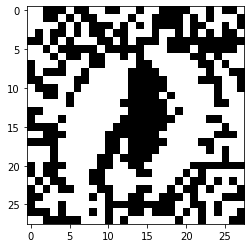

In [35]:
epsilon = 0.2
delta = epsilon * model.weight.detach().sign().view(28,28)
plt.imshow(1-delta.numpy(), cmap="gray")

## Observe adversarial training is robust to  perturbation

In [37]:
# the test error(0.02) under adversarial training model is smaller than traditional training model error(0.84)
# which indicate that the adversarial is robust to adversarial attack.
print(epoch_adv(test_loader, model, delta[None,None,:,:]))

(0.02458628841607565, 0.10157182580190348)
